In [1]:
### %%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

                
seed_number_range = []     
for num in range(2,3):
    seed_number_range.append(f'Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0,5,10,25,50,100,800]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}



Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

f0_name = {}
height = {}
y_loc = {}
f0_name_arr = []
for f0 in f0_range:
    step = 5
    if f0 >= 50: 
        step = 25
    if f0 >= 100: 
        step = 50
    lowcut = f0
    highcut = lowcut + step
    if f0 == 800:
        lowcut = 1
        highcut = f0 
    fname = f'F{lowcut}-{highcut} Hz'
    if f0 == 0:
        fname = f'NF'
    elif f0 == 1000:
        fname = 'Steps of 200 and 1-800'
    elif f0 == 1100:
        fname = 'Sine and original OU'
    elif f0 == 1200:
        fname = 'Sine and different filtered'
    elif f0 == 1300:
        fname = 'Sine added to OU'
    elif f0 == 1400:
        fname = 'Only sine different phases'
    elif f0 == 1500:
        fname = '5 11 53 101 199Hz sines'
    f0_name_arr.append(fname)
    f0_name[f0] = fname
    height[f0] = highcut-lowcut
    y_loc[f0] = (highcut+lowcut)/2

WARNING    <ipython-input-1-794435a5741e>:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-colorblind')
 [py.warnings]
  style.use('seaborn-colorblind')



# Figure 1 - A

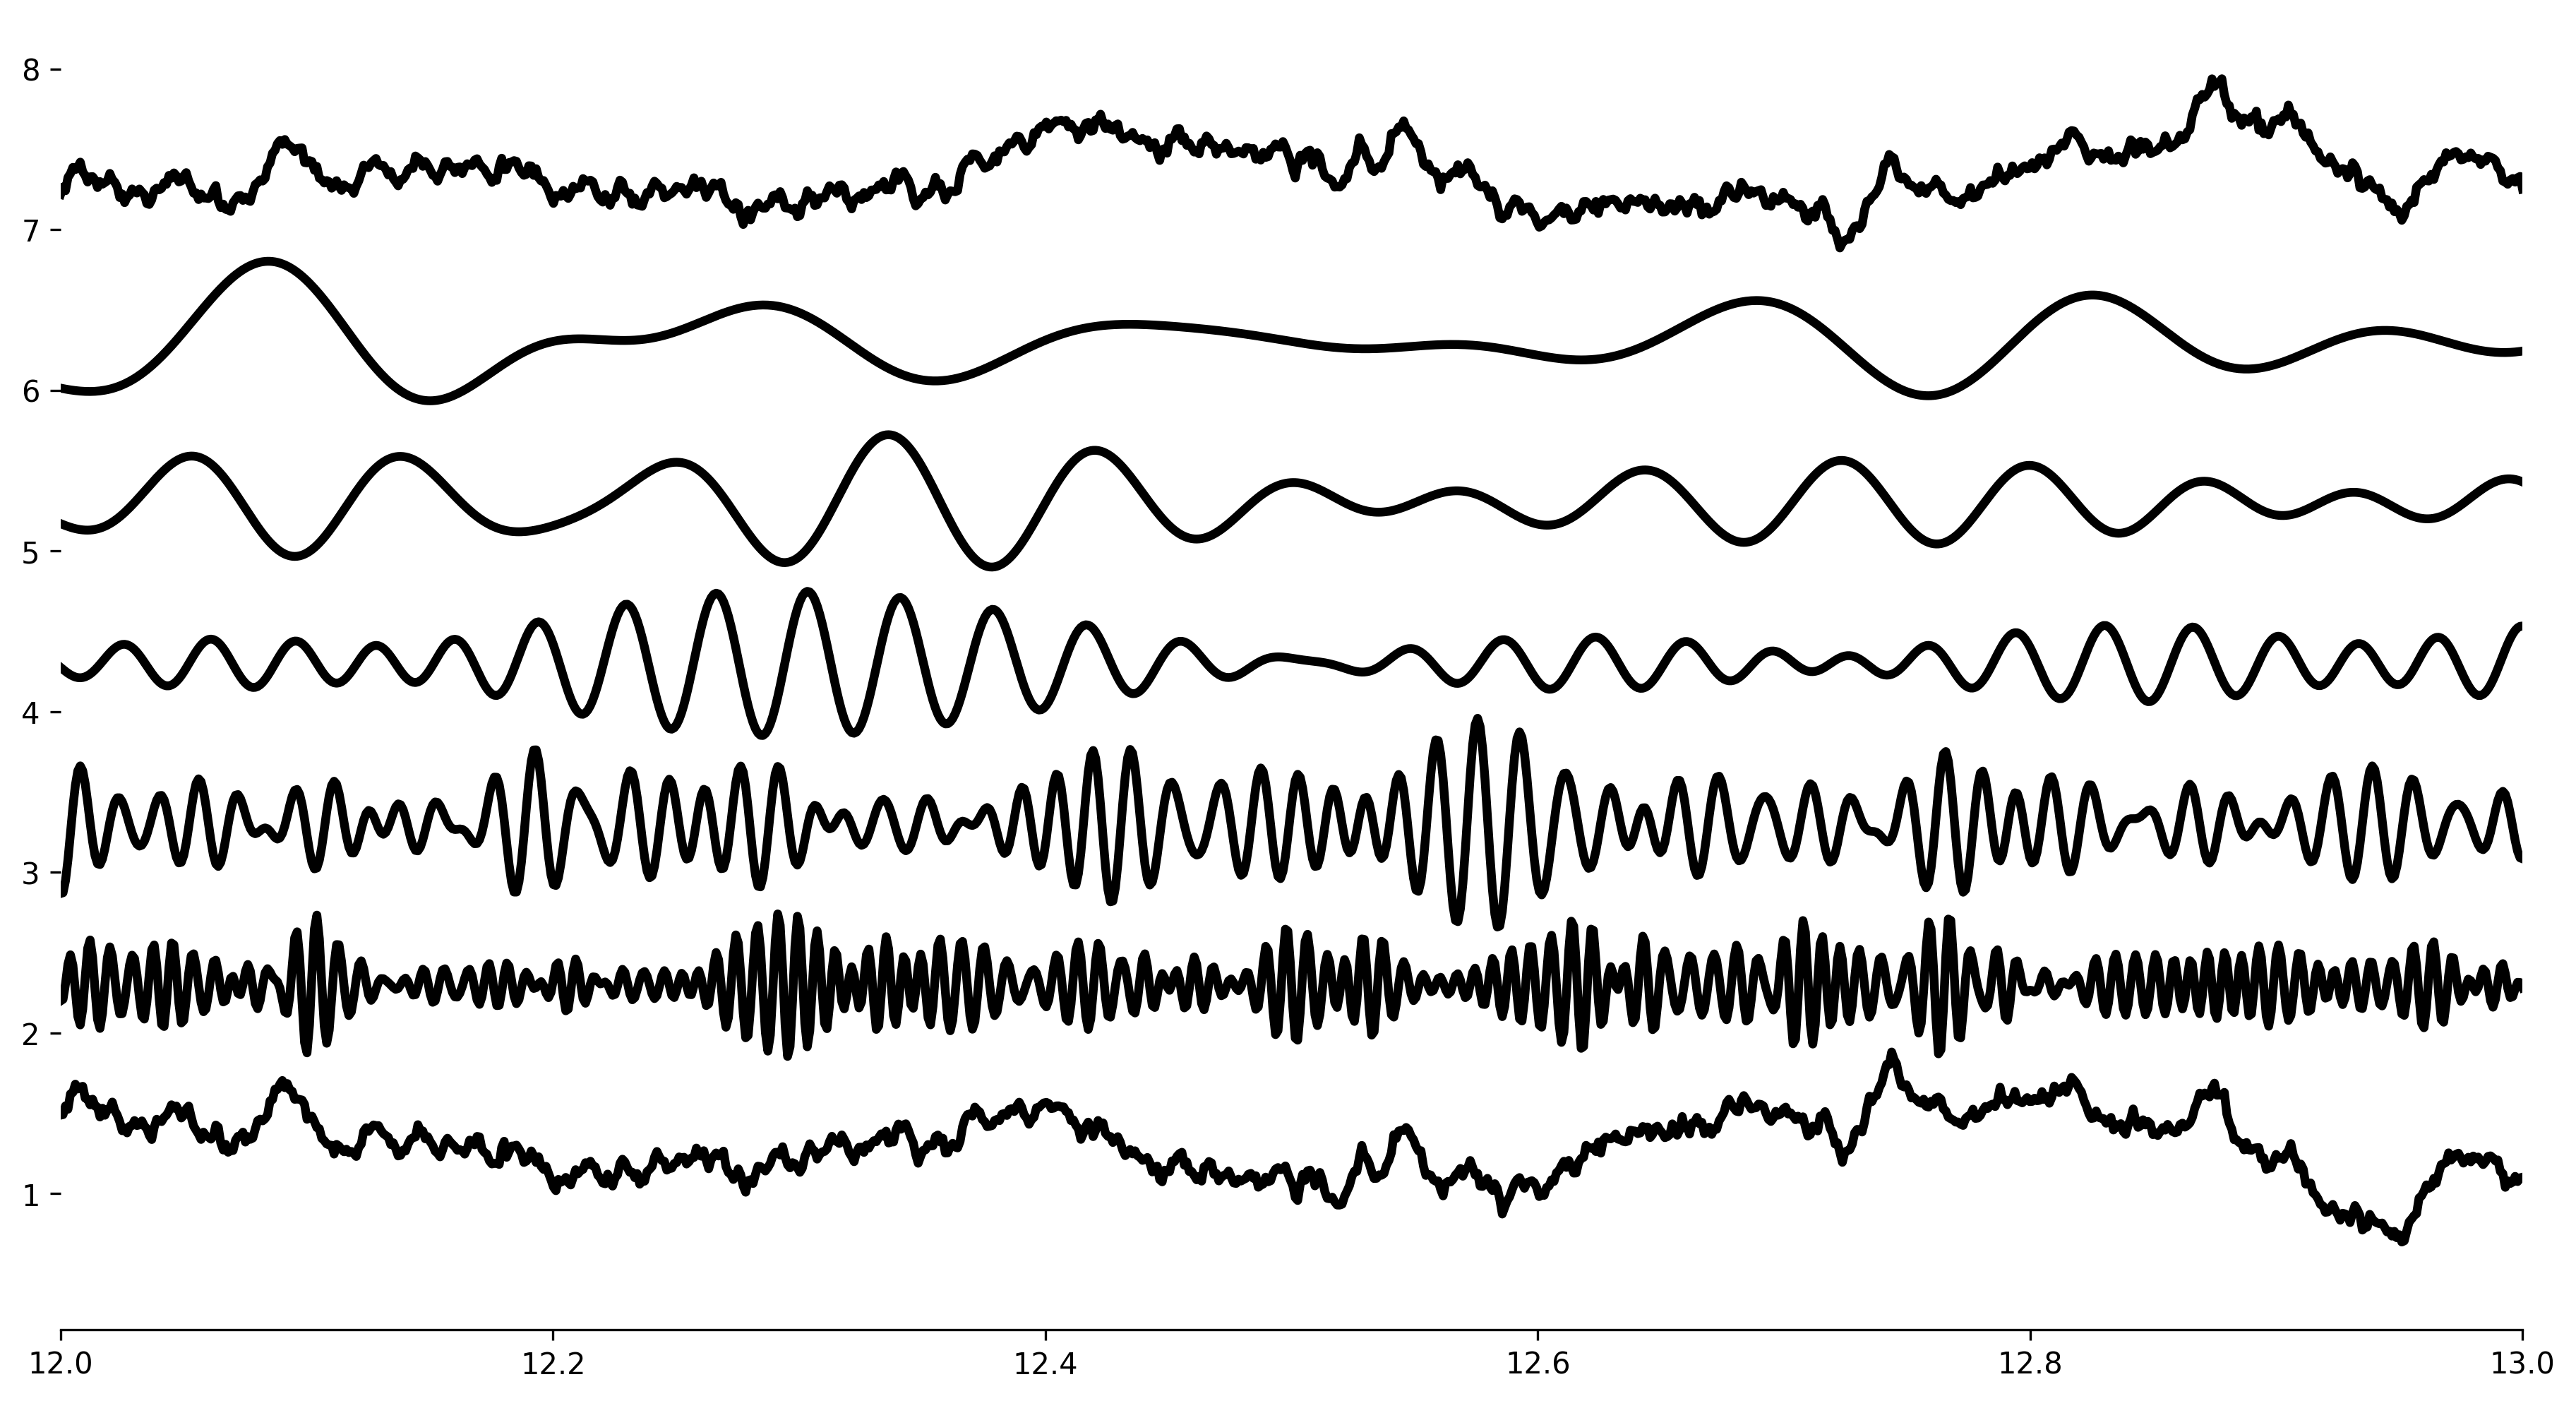

CPU times: user 1.2 s, sys: 3.89 s, total: 5.09 s
Wall time: 1.48 s


In [2]:
%%time

start = 12000
end = start+ 1000

colors_dict = dict(PF0='C4',PF1='C3',PF2='C2',PF3='C1',PF4='C0')
fig_size= (8,2)

cmap = plt.get_cmap('Greys')

figure(figsize=(15,8), dpi= 300, facecolor='w', edgecolor='k')
plasticity = 'no_Plasticity'
pf_num = 0
f0_range_rev = list(reversed(f0_range))
f0_name_arr_rev = reversed(f0_name_arr)
for idx,f0 in enumerate(f0_range_rev):    
    Noise_output = output_load_run('Noise',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    plot(linspace(start/1000,end/1000,int((end-start))),idx+Noise_output['I'][pf_num][start:end]/nA*amp,color=cmap((idx+10)/len(f0_range_rev)),lw=3)
#     yticks([])
xlim([start/1000,end/1000])
sns.despine(offset=10, trim=True, left=True)
plt.show()

# Figure 5 - B,D

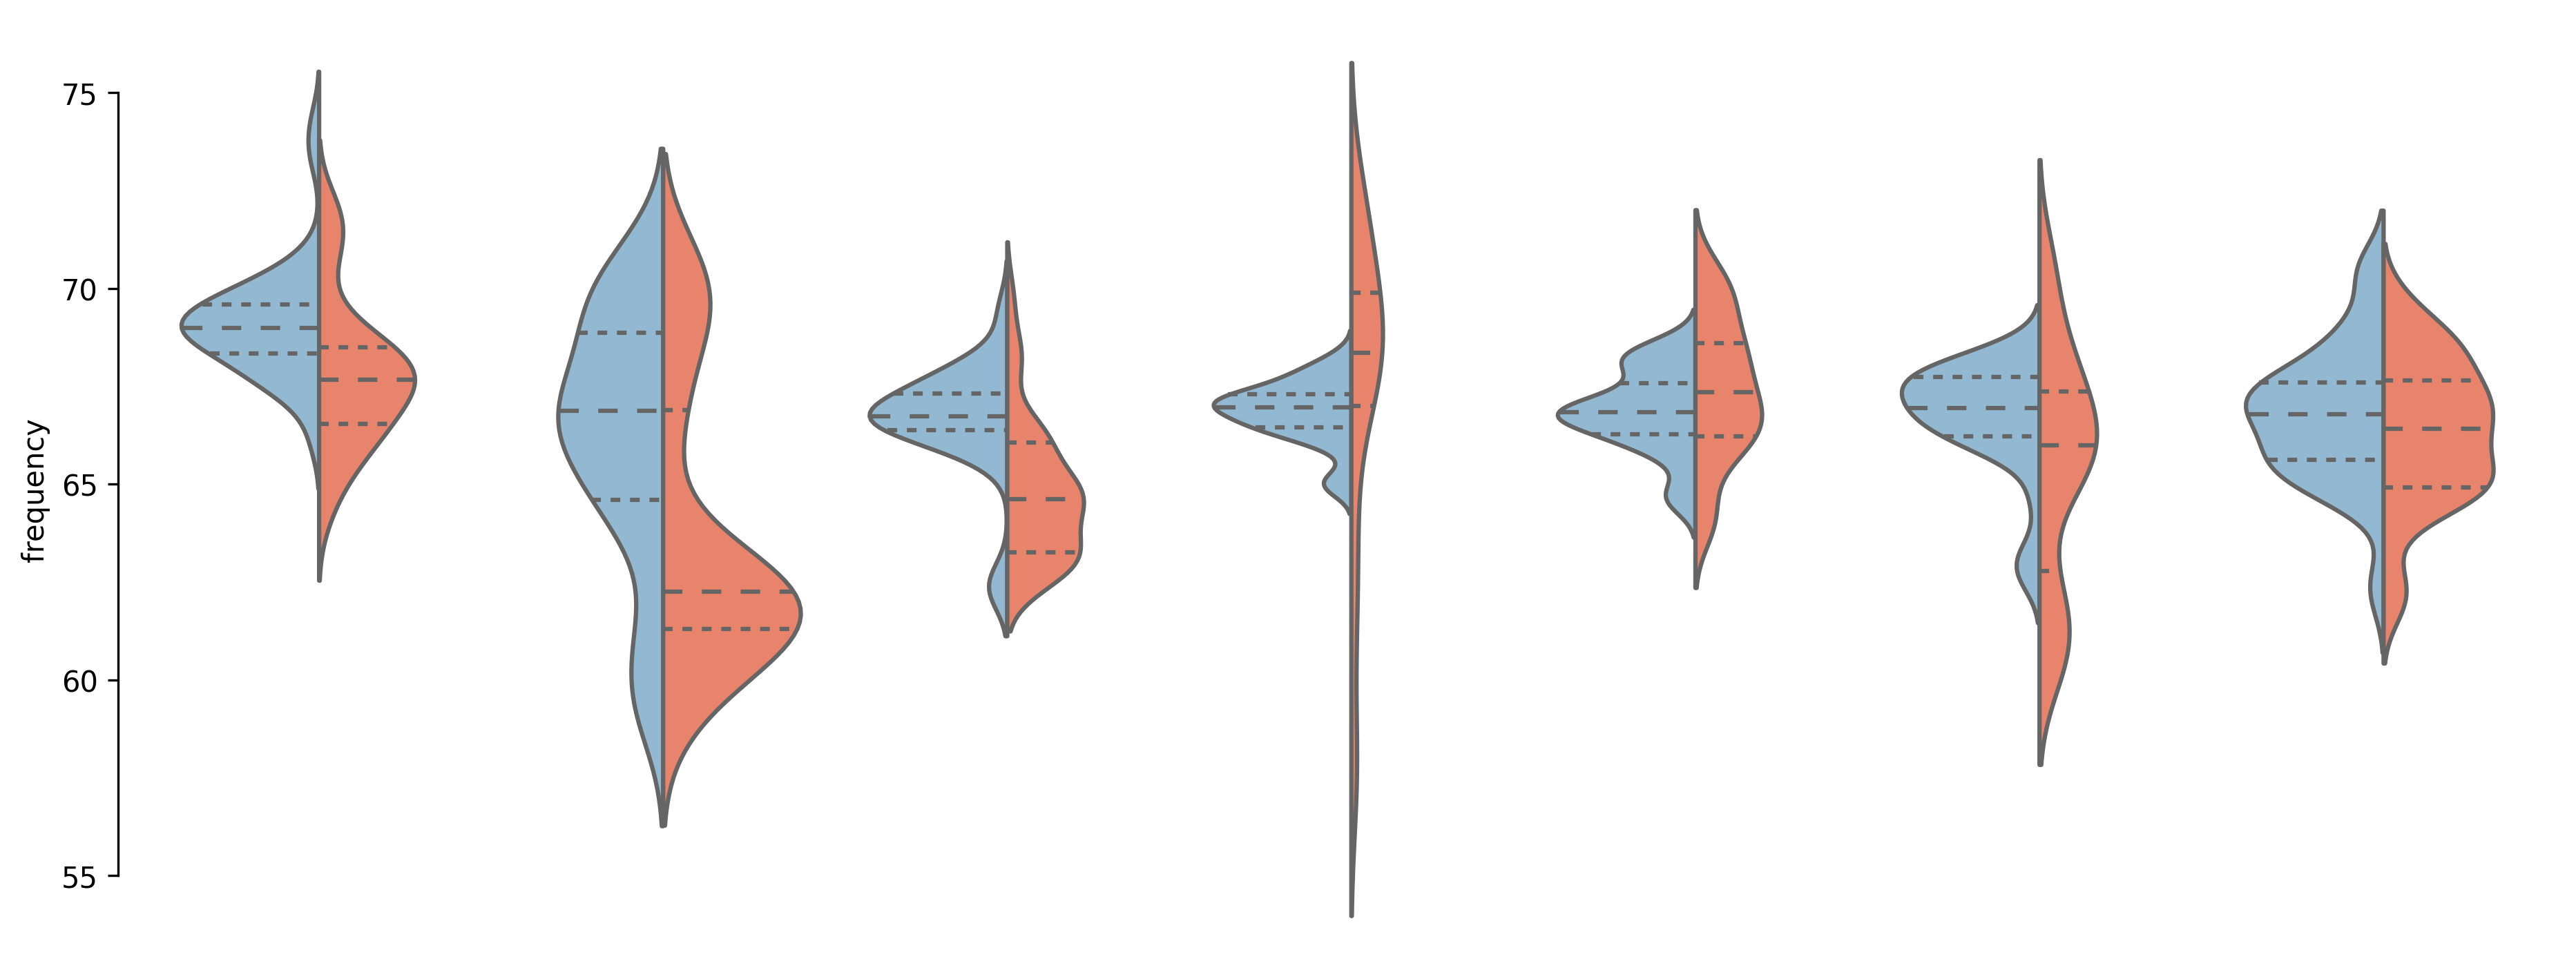

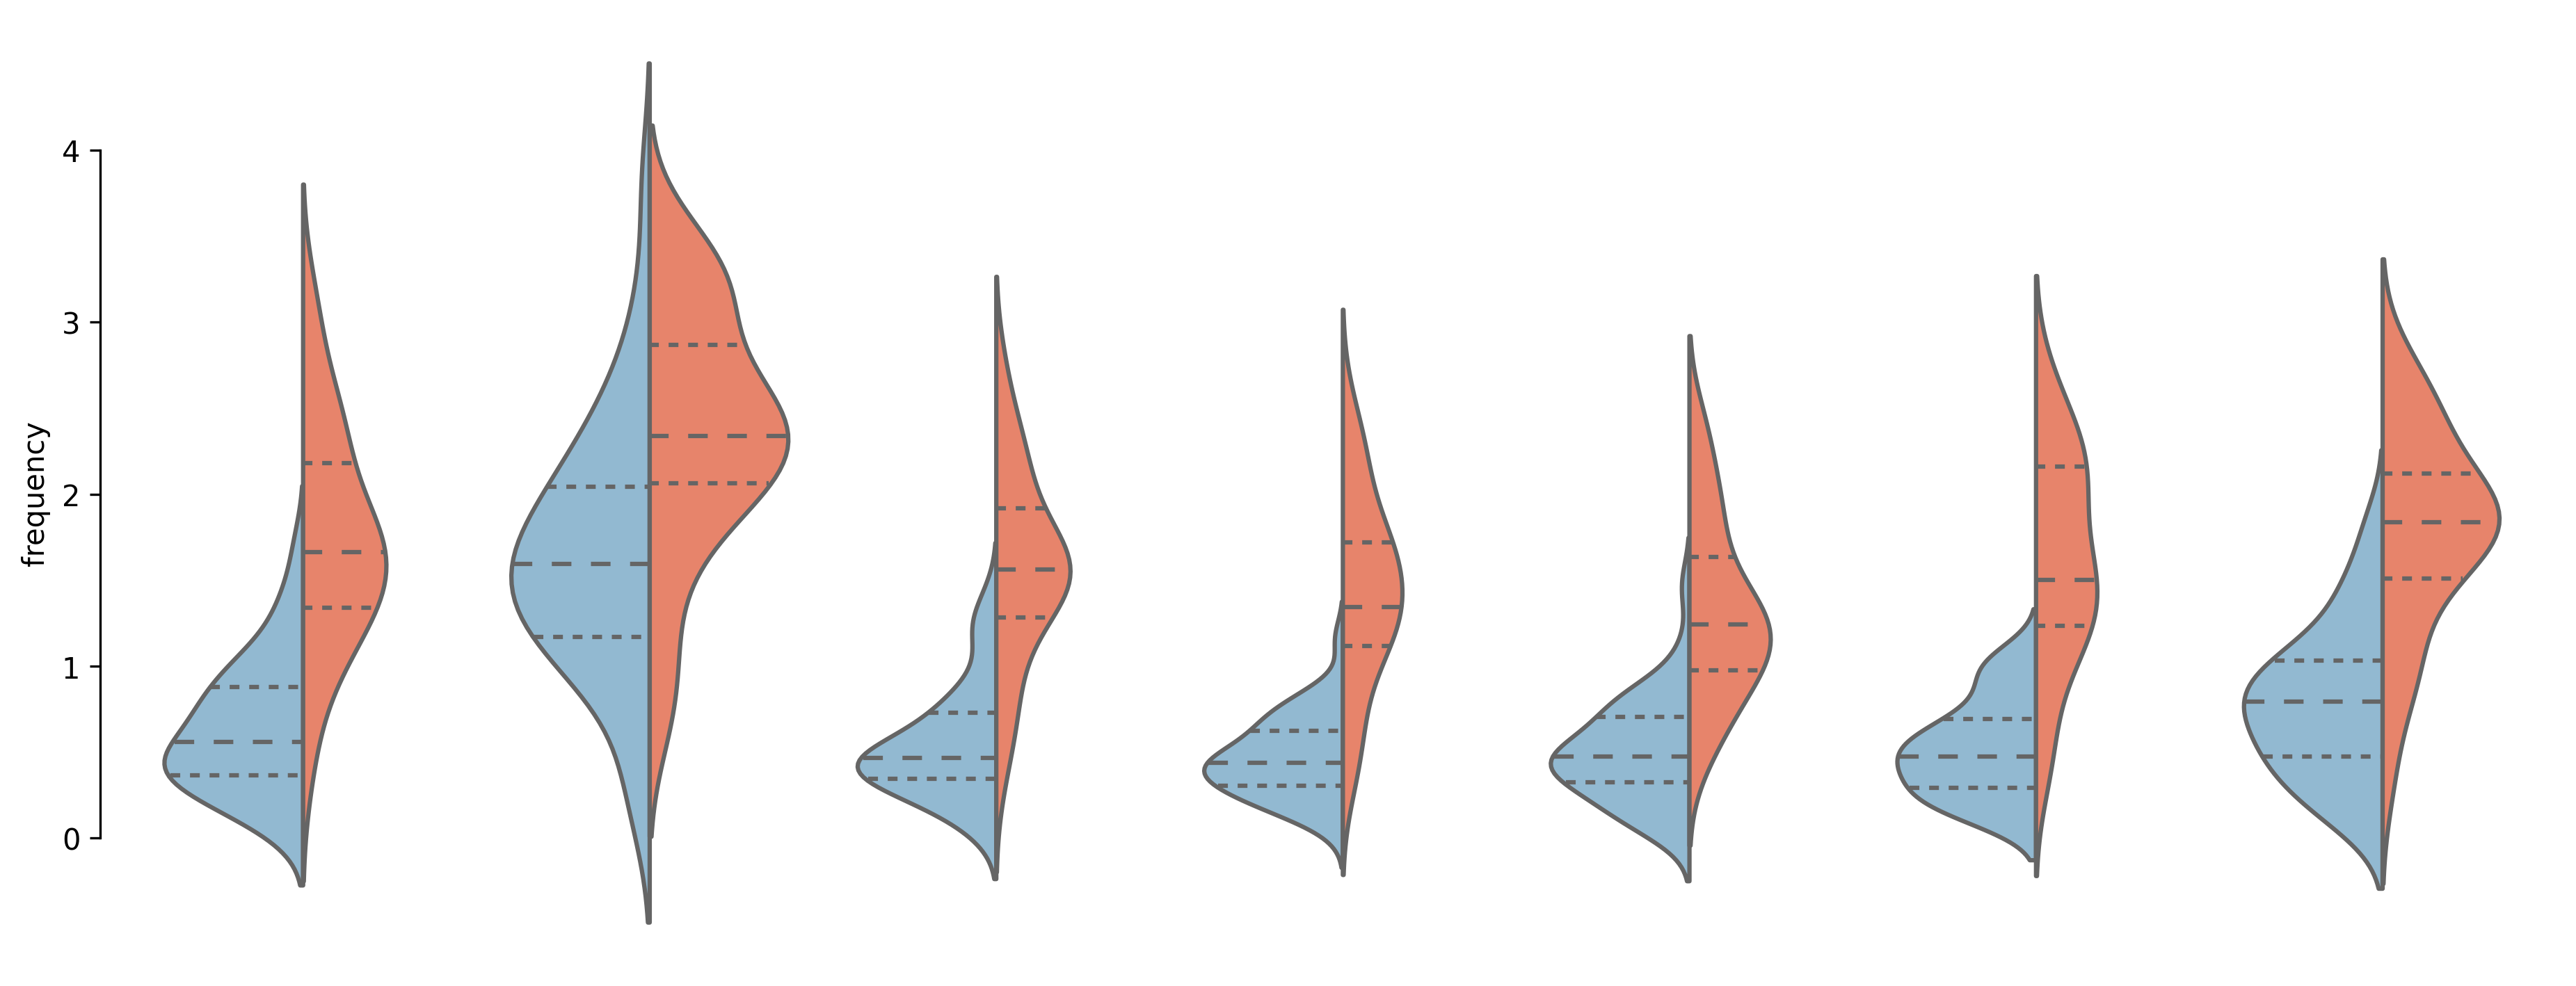

CPU times: user 4.61 s, sys: 8.96 s, total: 13.6 s
Wall time: 12.6 s


In [3]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'
bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)


data = []
for f0 in f0_range:
    for coupling in (['', '_Coupled']):
        for cell_name in ['PC','IO']:
            for zebrin in ['positive','negative']:
                for order,plasticity in enumerate(plasticity_range[0:3]):
                    spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for cell_num in range(cell_pop_sizes[cell_name]):
                        spikes = spikes_output[f'{cell_num}']
                        bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                        spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                        mean_count = spike_counts / bin_size
                        row = dict(frequency = mean(mean_count/Hz))
                        row['cell'] = cell_name
                        row['plasticity'] = plasticity
                        row['zebrin'] = zebrin
                        row['coupling'] = coupling
                        row['f0'] = f0_name[f0]
#                         row['order'] = f'{order}'+names[f'{plasticity}']
                        data.append(row)
df_ff = pd.DataFrame(data)


colors = dict(positive='#87bcdc8c',negative='#fb785746')
# colors = dict(positive='#2d5c91',negative='#a52b2e')
for coupling in ['_Coupled']:
    for cell_name in ['PC','IO']:
        for plasticity in plasticity_range[2:3]:
            data = df_ff[(df_ff.cell==cell_name)&(df_ff.coupling==coupling)&(df_ff.plasticity==plasticity)]
            figure(figsize=(15,6),dpi=300)
#             title(f'{cell_name} {plasticity}{coupling}',fontsize=16)
            ax = sns.violinplot(data=data, x="f0", y="frequency", hue="zebrin", split=True, gap=.1, inner="quart", legend=False, palette=colors)
            plt.setp(ax.collections, alpha=1)
#             ylim(40,90)
#             yticks(fontsize=16)
#             xticks(rotation=70,fontsize=16)
            xticks([])
            xlabel('')
            ax.legend_.remove()
            sns.despine(trim=True,bottom = True, offset=10)
            #range(len(f0_range)),f0_name_arr,rotation=45)
            plt.savefig(f'{cell_name}_violin.svg')
            plt.show()

# Figure 5 C

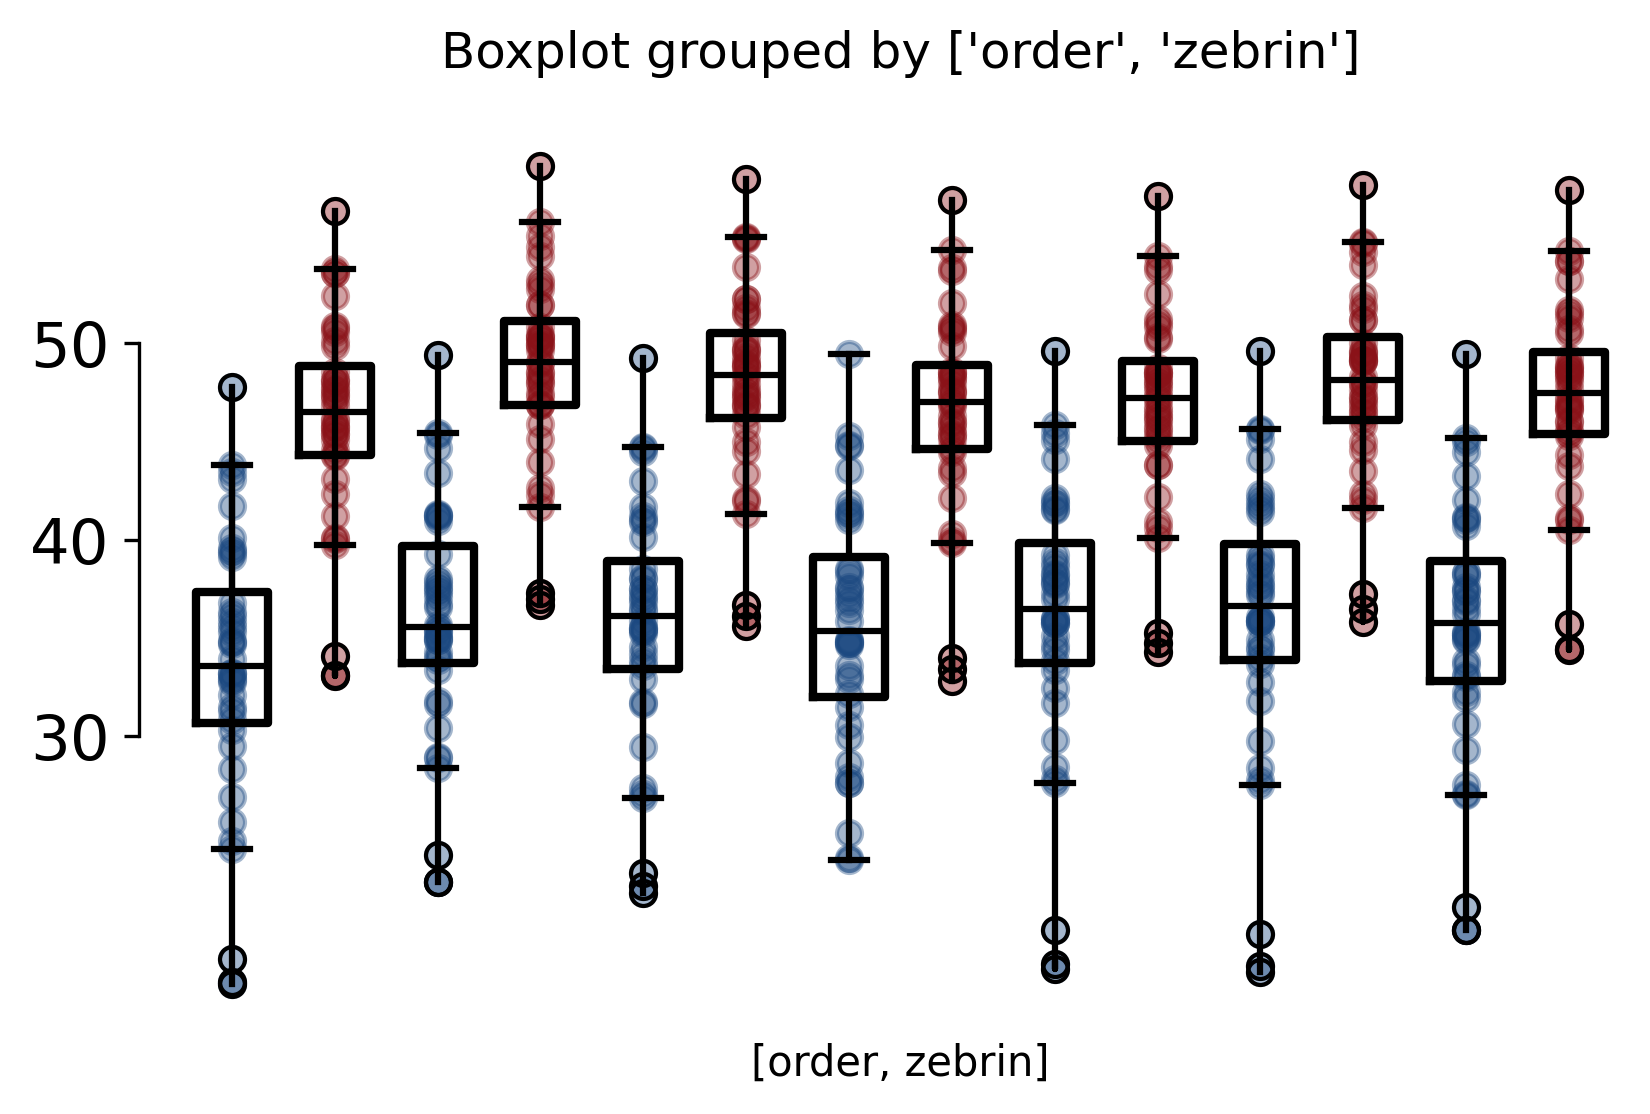

CPU times: user 1.15 s, sys: 178 ms, total: 1.32 s
Wall time: 4.08 s


In [4]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'

cmap = plt.get_cmap('Blues')
color_range=['#1c4981','#8a1218']
colors = dict(positive='#1c4981',negative='#8a1218')

zebrin_range = ['negative','positive']

names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)

data = []
zebrin_range = ['positive','negative']
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','DCN','IO']:
        for zebrin in zebrin_range:
            zeb_num = 0
            if zebrin == 'negative': zeb_num = 1
            idx=0
            for f0 in f0_range:
                for order,plasticity in enumerate(plasticity_range[2:3]):
                    spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for cell_num in range(cell_pop_sizes[cell_name]):
                        spikes = spikes_output[f'{cell_num}']
                        bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                        spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                        mean_count = spike_counts / bin_size
                        row = dict(frequency = mean(mean_count/Hz))
                        row['cell'] = cell_name
                        row['plasticity'] = names[f'{plasticity}']
                        row['zebrin'] = zebrin
                        row['coupling'] = coupling
                        row['f0'] = f0
                        row['order'] = f'{idx}{zeb_num}'+names[f'{plasticity}']
                        data.append(row)
                    idx+=1
df_ff = pd.DataFrame(data)

var = 'frequency'
zebrin_range = ['positive','negative']
for coupling in (['_Coupled']):#, '']):
    for cell_name in ['DCN']:#['PC','IO','DCN']:
        df_data = df_ff[(df_ff["coupling"]==coupling) & (df_ff["cell"]==cell_name)]
        Q1, Q3 = percentile(df_data['frequency'],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
        fig = plt.figure(dpi=300)
        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['order','zebrin'], grid=False, figsize=(4,3), widths=0.7, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca())  
        title(f'')#Firing frequency {plasticity}{coupling}')
        colors = dict(positive='#1c4981',negative='#8a1218')
        for idx,f0 in enumerate(f0_range):
            for i,zebrin in enumerate(zebrin_range):
                for j,plasticity in enumerate(plasticity_range[2:3]):
                    y = df_data2.frequency[(df_data2.f0==f0) & (df_data2.zebrin==zebrin) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
                    x = [idx*2+1+j+(len(plasticity_range[2:3]))*i]*len(y)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
                    scatter(x, y, color=f'{colors[zebrin]}', alpha=0.4)
                xticks([])
#         xticks(rotation=90)
        if cell_name == 'IO': yticks(np.arange(0.5, 1.5+0.1, 0.5))
        elif cell_name == 'DCN': yticks(np.arange(30, 60, 10))
        sns.despine(trim=True,bottom = True,offset = 10)
        plt.savefig(f'{cell_name}_boxplot.svg')
        plt.show()

# Figure 5 - E

In [5]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'
from scipy.stats import variation

cmap = plt.get_cmap('Blues')
color_range=['#1c4981','#8a1218']
colors = dict(positive='#1c4981',negative='#8a1218')

zebrin_range = ['negative','positive']

names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)

data = []
zebrin_range = ['positive','negative']
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','DCN','IO']:
        for zebrin in zebrin_range:
            zeb_num = 0
            if zebrin == 'negative': zeb_num = 1
            idx=0
            for f0 in f0_range:
                for order,plasticity in enumerate(plasticity_range[2:3]):
                    spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                    for cell_num in range(cell_pop_sizes[cell_name]):
                        spikes = spikes_output[f'{cell_num}']
                        cv_arr = variation(spikes_output[f'{cell_num}'], axis=0)
                        row = dict(cv = cv_arr)
                        row['cell'] = cell_name
                        row['plasticity'] = names[f'{plasticity}']
                        row['zebrin'] = zebrin
                        row['coupling'] = coupling
                        row['f0'] = f0
                        row['order'] = f'{idx}{zeb_num}'+names[f'{plasticity}']
                        data.append(row)
                    idx+=1
df_cv = pd.DataFrame(data)



CPU times: user 591 ms, sys: 87.4 ms, total: 679 ms
Wall time: 3.04 s


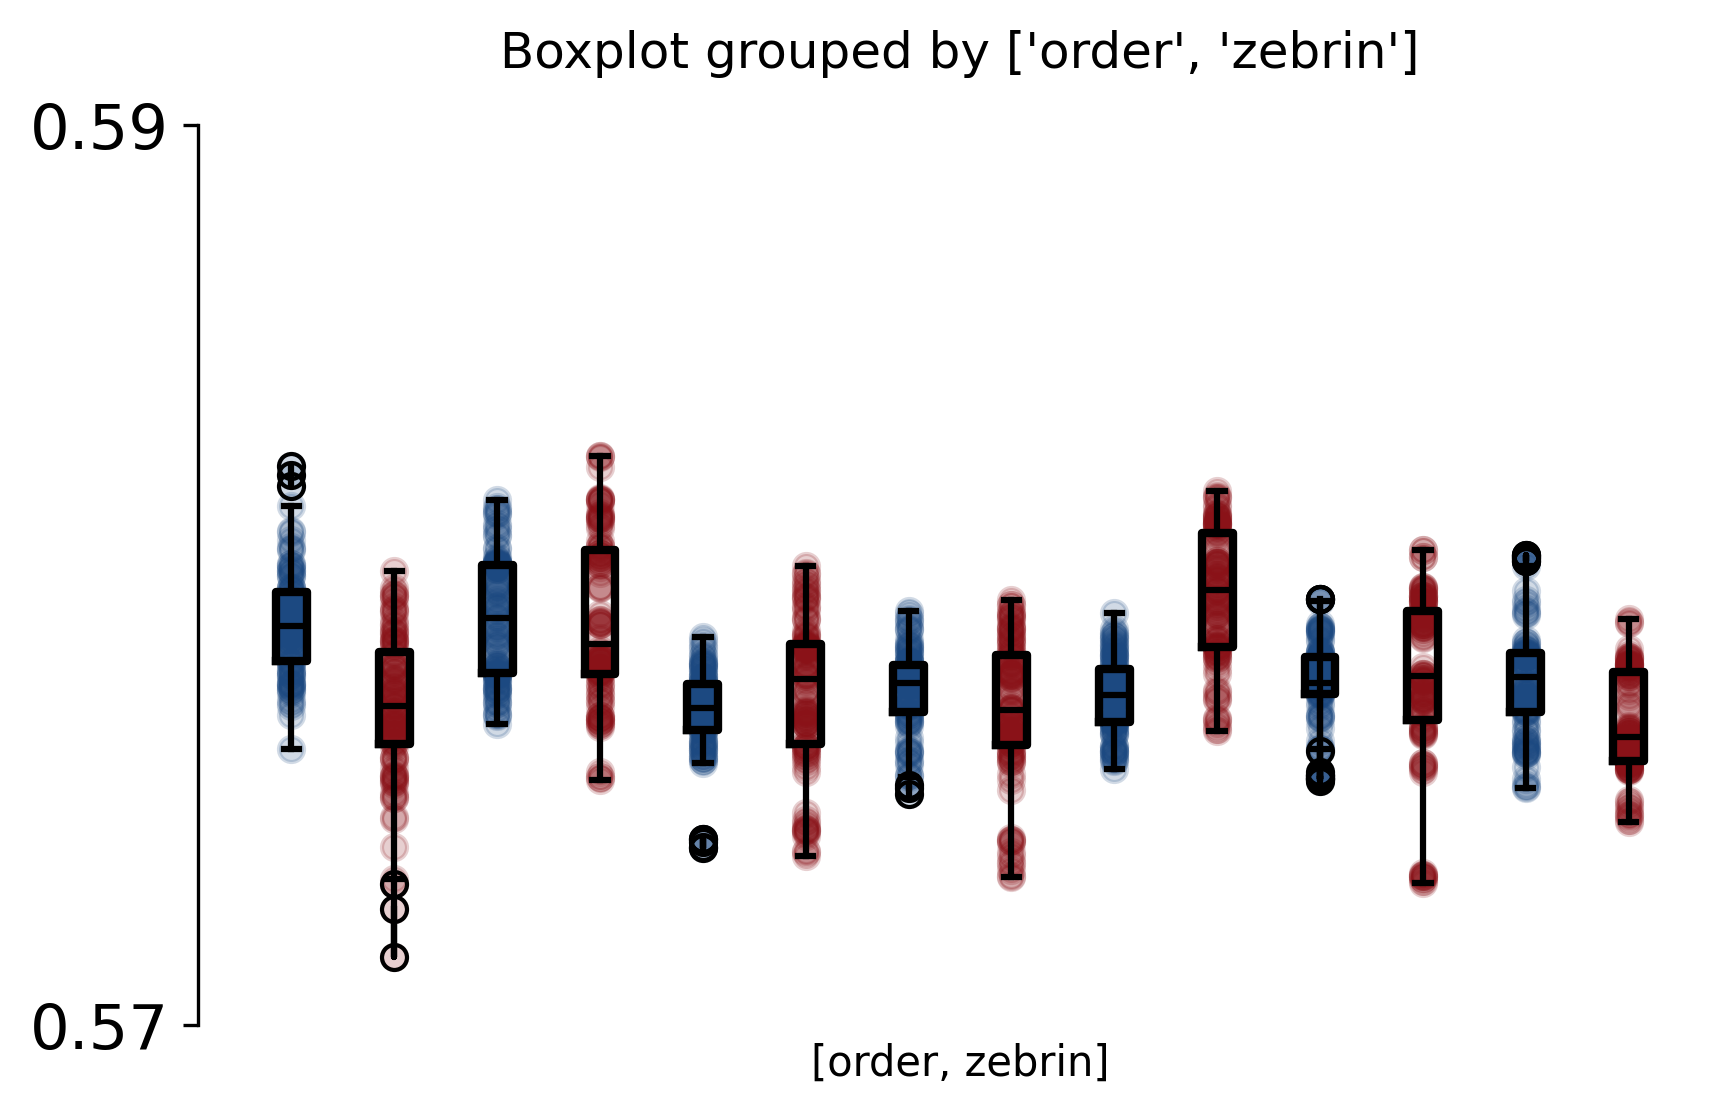

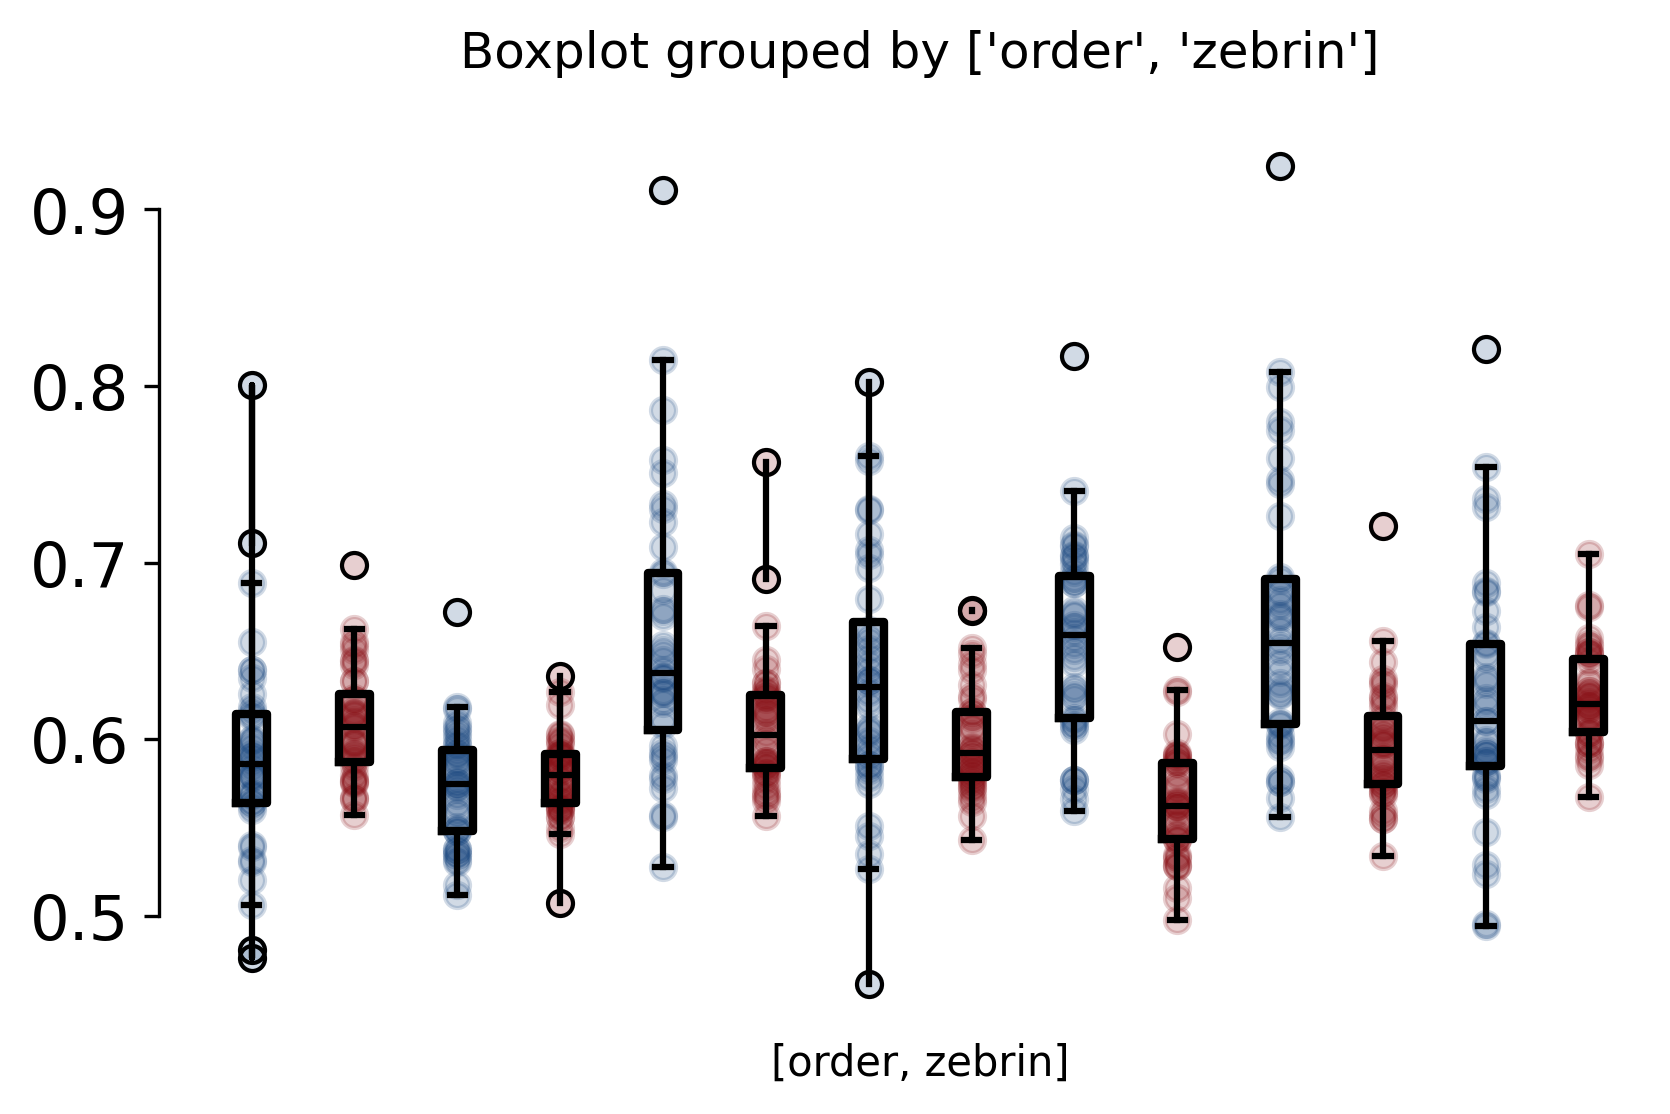

In [6]:
var = 'cv'
zebrin_range = ['positive','negative']
for coupling in (['_Coupled']):#, '']):
    for cell_name in ['PC','IO']:#['PC','IO','DCN']:
        df_data = df_cv[(df_cv["coupling"]==coupling) & (df_cv["cell"]==cell_name)]
        Q1, Q3 = percentile(df_data[var],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
        fig = plt.figure(dpi=300)
        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['order','zebrin'], grid=False, figsize=(4,3), widths=0.3, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca())  
        title(f'')#Firing frequency {plasticity}{coupling}')
        colors = dict(positive='#1c4981',negative='#8a1218')
        for idx,f0 in enumerate(f0_range):
            for i,zebrin in enumerate(zebrin_range):
                for j,plasticity in enumerate(plasticity_range[2:3]):
                    y = df_data2.cv[(df_data2.f0==f0) & (df_data2.zebrin==zebrin) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
                    x = [idx*2+1+j+(len(plasticity_range[2:3]))*i]*len(y)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
                    scatter(x, y, color=f'{colors[zebrin]}', alpha=0.2)
                xticks([])
#         xticks(rotation=90)
        if cell_name == 'PC': 
            yticks([0.57,0.59])
            ylim([0.57,0.59])
#         elif cell_name == 'DCN': yticks(np.arange(30, 60, 10))
        sns.despine(trim=True,bottom = True,offset = 10)
        plt.savefig(f'{cell_name}_cv_boxplot.svg')
        plt.show()